In [1]:
from builtins import range
from __future__ import division
import numpy as np

In [2]:
def affine_forward(x, w, b):
    out = None
    # x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    # w: A numpy array of weights, of shape (D, M)
    # b: A numpy array of biases, of shape (M,)
    
    #out: output, of shape (N, M)
    #cache: (x, w, b)
    out = np.dot(x.reshape(x.shape[0], -1), w) + b
    
    cache = (x,w,b)
    return cache, out


def affine_backword(dout, cache):
    #dout : Upstream derivative, of shape (N, M)
    #cache : (x,w,b)
    
    """
    
    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    
    dx = np.dot(dout,w.T).reshape(x.shape)
    dw = np.dot(x.reshape(x.shape[0], -1).T,dout)
    db = np.sum(dout, axis=0)
    
    return dx, dw, db

def relu_forward(x):
    """
    
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    
    """
    out = None
    out = np.maximum(0, x)
    cache = x
    return out, cache

def relu_backword(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    
    dx, x = None, cache
    dx = (x > 0) * dout
    return dx



def batchnorm_forward(x, gamma, beta, bn_param):
    """
     Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift parameter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var: Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        # Mean
        mu = np.mean(x, axis=0)
        # Variance
        var = 1 / float(N) * np.sum((x - mu) ** 2, axis=0)
        # Normalized Data
        x_hat = (x - mu) / np.sqrt(var + eps)
        # Scale and Shift
        y = gamma * x_hat + beta
        out = y

        # Make the record of means and variances in running parameters
        running_mean = momentum * running_mean + (1 - momentum) * mu
        running_var = momentum * running_var + (1 - momentum) * var

        # TODO: Cache
        cache = (x_hat, mu, var, eps, gamma, beta, x)
        
        
    elif mode == 'test':
        x_hat = (x - running_mean) / np.sqrt(running_var + eps)
        # Scale and Shift
        y = gamma * x_hat + beta
        out = y
        
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)
        
    
        
    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache


def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    
    x_hat, mu, var, eps, gamma, beta, x = cache
    N, D = dout.shape

    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout * x_hat, axis=0)

    # for dx visit this backprop diagram:
    # https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html
    dx_hat = dout * gamma
    dxmu1 = dx_hat * 1 / np.sqrt(var + eps)
    divar = np.sum(dx_hat * (x - mu), axis=0)
    dvar = divar * -1 / 2 * (var + eps) ** (-3/2)
    dsq = 1 / N * np.ones((N, D)) * dvar
    dxmu2 = 2 * (x - mu) * dsq
    dx1 = dxmu1 + dxmu2
    dmu = -1 * np.sum(dxmu1 + dxmu2, axis=0)
    dx2 = 1 / N * np.ones((N, D)) * dmu
    dx = dx1 + dx2

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta




def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We drop each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not
        in real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':
        #######################################################################
        # TODO: Implement training phase forward pass for inverted dropout.   #
        # Store the dropout mask in the mask variable.                        #
        #######################################################################

        mask = (np.random.rand(*x.shape) < p) / p
        out = x * mask

        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == 'test':
        #######################################################################
        # TODO: Implement the test phase forward pass for inverted dropout.   #
        #######################################################################

        out = x

        #######################################################################
        #                            END OF YOUR CODE                         #
        #######################################################################

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache


def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']

    dx = None
    if mode == 'train':
        #######################################################################
        # TODO: Implement training phase backward pass for inverted dropout   #
        #######################################################################

        dx = dout * mask

        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    elif mode == 'test':
        dx = dout
    return dx


def conv_forward_naive(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width HH.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """
    out = None
    ###########################################################################
    # TODO: Implement the convolutional forward pass.                         #
    # Hint: you can use the function np.pad for padding.                      #
    ###########################################################################

    # Extract shapes and constants
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    stride = conv_param.get('stride', 1)
    pad = conv_param.get('pad', 0)
    # Check for parameter sanity
    assert (H + 2 * pad - HH) % stride == 0, 'Sanity Check Status: Conv Layer Failed in Height'
    assert (W + 2 * pad - WW) % stride == 0, 'Sanity Check Status: Conv Layer Failed in Width'
    H_prime = 1 + (H + 2 * pad - HH) // stride
    W_prime = 1 + (W + 2 * pad - WW) // stride
    # Padding
    x_pad = np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), 'constant', constant_values=0)
    # Construct output
    out = np.zeros((N, F, H_prime, W_prime))
    # Naive Loops
    for n in range(N):
        for f in range(F):
            for j in range(0, H_prime):
                for i in range(0, W_prime):
                    out[n, f, j, i] = (x_pad[n, :, j*stride:j*stride+HH, i*stride:i*stride+WW] * w[f, :, :, :]).sum() + b[f]

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b, conv_param)
    return out, cache


def conv_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - dout: Upstream derivatives of shape (N, F, H', W')
    - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the convolutional backward pass.                        #
    ###########################################################################

    # Extract shapes and constants
    x, w, b, conv_param = cache
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    stride = conv_param.get('stride', 1)
    pad = conv_param.get('pad', 0)
    # Padding
    x_pad = np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), 'constant', constant_values=0)
    H_prime = 1 + (H + 2 * pad - HH) // stride
    W_prime = 1 + (W + 2 * pad - WW) // stride
    # Construct output
    dx_pad = np.zeros_like(x_pad)
    dx = np.zeros_like(x)
    dw = np.zeros_like(w)
    db = np.zeros_like(b)
    # Naive Loops
    for n in range(N):
        for f in range(F):
            db[f] += dout[n, f].sum()
            for j in range(0, H_prime):
                for i in range(0, W_prime):
                    dw[f] += x_pad[n, :, j * stride:j * stride + HH, i * stride:i * stride + WW] * dout[n, f, j, i]
                    dx_pad[n, :, j * stride:j * stride + HH, i * stride:i * stride + WW] += w[f] * dout[n, f, j, i]
    # Extract dx from dx_pad
    dx = dx_pad[:, :, pad:pad+H, pad:pad+W]

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db


def max_pool_forward_naive(x, pool_param):
    """
    A naive implementation of the forward pass for a max pooling layer.

    Inputs:
    - x: Input data, of shape (N, C, H, W)
    - pool_param: dictionary with the following keys:
      - 'pool_height': The height of each pooling region
      - 'pool_width': The width of each pooling region
      - 'stride': The distance between adjacent pooling regions

    Returns a tuple of:
    - out: Output data
    - cache: (x, pool_param)
    """
    out = None
    ###########################################################################
    # TODO: Implement the max pooling forward pass                            #
    ###########################################################################

    # Extract shapes and constants
    N, C, H, W = x.shape
    HH = pool_param.get('pool_height', 2)
    WW = pool_param.get('pool_width', 2)
    stride = pool_param.get('stride', 2)
    assert (H - HH) % stride == 0, 'Sanity Check Status: Max Pool Failed in Height'
    assert (W - WW) % stride == 0, 'Sanity Check Status: Max Pool Failed in Width'
    H_prime = 1 + (H - HH) // stride
    W_prime = 1 + (W - WW) // stride
    # Construct output
    out = np.zeros((N, C, H_prime, W_prime))
    # Naive Loops
    for n in range(N):
        for j in range(H_prime):
            for i in range(W_prime):
                out[n, :, j, i] = np.amax(x[n, :, j*stride:j*stride+HH, i*stride:i*stride+WW], axis=(-1, -2))

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, pool_param)
    return out, cache


def max_pool_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a max pooling layer.

    Inputs:
    - dout: Upstream derivatives
    - cache: A tuple of (x, pool_param) as in the forward pass.

    Returns:
    - dx: Gradient with respect to x
    """
    dx = None
    ###########################################################################
    # TODO: Implement the max pooling backward pass                           #
    ###########################################################################

    # Extract constants and shapes
    x, pool_param = cache
    N, C, H, W = x.shape
    HH = pool_param.get('pool_height', 2)
    WW = pool_param.get('pool_width', 2)
    stride = pool_param.get('stride', 2)
    H_prime = 1 + (H - HH) // stride
    W_prime = 1 + (W - WW) // stride
    # Construct output
    dx = np.zeros_like(x)
    # Naive Loops
    for n in range(N):
        for c in range(C):
            for j in range(H_prime):
                for i in range(W_prime):
                    ind = np.argmax(x[n, c, j*stride:j*stride+HH, i*stride:i*stride+WW])
                    ind1, ind2 = np.unravel_index(ind, (HH, WW))
                    dx[n, c, j*stride:j*stride+HH, i*stride:i*stride+WW][ind1, ind2] = dout[n, c, j, i]

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx


def spatial_batchnorm_forward(x, gamma, beta, bn_param):
    """
    Computes the forward pass for spatial batch normalization.

    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (C,)
    - beta: Shift parameter, of shape (C,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance. momentum=0 means that
        old information is discarded completely at every time step, while
        momentum=1 means that new information is never incorporated. The
        default of momentum=0.9 should work well in most situations.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    out, cache = None, None

    ###########################################################################
    # TODO: Implement the forward pass for spatial batch normalization.       #
    #                                                                         #
    # HINT: You can implement spatial batch normalization using the vanilla   #
    # version of batch normalization defined above. Your implementation should#
    # be very short; ours is less than five lines.                            #
    ###########################################################################

    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, C, H, W = x.shape
    running_mean = bn_param.get('running_mean', np.zeros((1, C, 1, 1), dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros((1, C, 1, 1), dtype=x.dtype))

    if mode == 'train':
        # Mean
        mu = np.mean(x, axis=(0, 2, 3)).reshape(1, C, 1, 1)
        # Variance
        var = 1 / float(N * H * W) * np.sum((x - mu) ** 2, axis=(0, 2, 3)).reshape(1, C, 1, 1)
        # Normalized Data
        x_hat = (x - mu) / np.sqrt(var + eps)
        # Scale and Shift
        y = gamma.reshape(1, C, 1, 1) * x_hat + beta.reshape(1, C, 1, 1)
        out = y

        # Make the record of means and variances in running parameters
        running_mean = momentum * running_mean + (1 - momentum) * mu
        running_var = momentum * running_var + (1 - momentum) * var

        cache = (x_hat, mu, var, eps, gamma, beta, x)

    elif mode == 'test':
        # Normalized Data
        x_hat = (x - running_mean) / np.sqrt(running_var + eps)
        # Scale and Shift
        y = gamma.reshape(1, C, 1, 1) * x_hat + beta.reshape(1, C, 1, 1)
        out = y

    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return out, cache


def spatial_batchnorm_backward(dout, cache):
    """
    Computes the backward pass for spatial batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H, W)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient with respect to inputs, of shape (N, C, H, W)
    - dgamma: Gradient with respect to scale parameter, of shape (C,)
    - dbeta: Gradient with respect to shift parameter, of shape (C,)
    """
    dx, dgamma, dbeta = None, None, None

    ###########################################################################
    # TODO: Implement the backward pass for spatial batch normalization.      #
    #                                                                         #
    # HINT: You can implement spatial batch normalization using the vanilla   #
    # version of batch normalization defined above. Your implementation should#
    # be very short; ours is less than five lines.                            #
    ###########################################################################

    x_hat, mu, var, eps, gamma, beta, x = cache
    N, C, H, W = dout.shape

    dbeta = np.sum(dout, axis=(0, 2, 3))
    dgamma = np.sum(dout * x_hat, axis=(0, 2, 3))

    # for dx visit this backprop diagram:
    # https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html

    gamma_reshape = gamma.reshape(1, C, 1, 1)
    beta_reshape = beta.reshape(1, C, 1, 1)
    Nt = N * H * W

    dx_hat = dout * gamma_reshape
    dxmu1 = dx_hat * 1 / np.sqrt(var + eps)
    divar = np.sum(dx_hat * (x - mu), axis=(0, 2, 3)).reshape(1, C, 1, 1)
    dvar = divar * -1 / 2 * (var + eps) ** (-3 / 2)
    dsq = 1 / Nt * np.broadcast_to(np.broadcast_to(np.squeeze(dvar), (W, H, C)).transpose(2, 1, 0), (N, C, H, W))
    dxmu2 = 2 * (x - mu) * dsq
    dx1 = dxmu1 + dxmu2
    dmu = -1 * np.sum(dxmu1 + dxmu2, axis=(0, 2, 3))
    dx2 = 1 / Nt * np.broadcast_to(np.broadcast_to(np.squeeze(dmu), (W, H, C)).transpose(2, 1, 0), (N, C, H, W))
    dx = dx1 + dx2

    # حاجی، پشمام

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta


def svm_loss(x, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    N = x.shape[0]
    correct_class_scores = x[np.arange(N), y]
    margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    num_pos = np.sum(margins > 0, axis=1)
    dx = np.zeros_like(x)
    dx[margins > 0] = 1
    dx[np.arange(N), y] -= num_pos
    dx /= N
    return loss, dx


def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx

        
    
    
    
    

In [3]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

In [4]:
x_train =unpickle('cifar-10/data_batch_1')['data']
x_train = x_train.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
x_train = x_train.transpose(0, 3, 1, 2).copy()
y_train = unpickle('cifar-10/data_batch_1')['labels']

print np.shape(x_train),'\n',np.shape(y_train),'\n',y_train[6]

(10000, 3, 32, 32) 
(10000,) 
2


In [5]:
x_test =unpickle('cifar-10/data_batch_4')['data']
x_test = x_test.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
x_test = x_test.transpose(0, 3, 1, 2).copy()
y_test = unpickle('cifar-10/data_batch_4')['labels']

print np.shape(x_test),'\n',np.shape(y_test),'\n',y_test[6]

(10000, 3, 32, 32) 
(10000,) 
1


In [6]:
print np.shape(x_test[0])

(3, 32, 32)


In [7]:
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

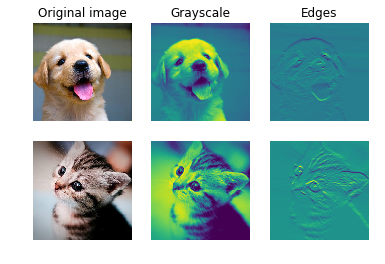

In [8]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

In [9]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [10]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-8'
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
('dx error: ', 1.1598031611592931e-08)
('dw error: ', 2.2471264748452487e-10)
('db error: ', 3.37264006649648e-11)


In [11]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
('difference: ', 4.1666665157267834e-08)


In [12]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be around 1e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
('dx error: ', 3.2756251422314499e-12)


In [13]:
from cv_API.vect_layers import conv_forward_im2col
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_im2col(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

Testing conv_forward_fast:
Naive: 3.655915s
Fast: 0.011032s
Speedup: 331.395885x
('Difference: ', 4.9264078514941052e-11)
